In [1]:
import numpy as np
import pandas as pd
from typing import Optional, List

import sklearn.base

seed = 24

In [2]:
data = pd.read_csv('./data.csv')


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

In [3]:
from sklearn.model_selection import train_test_split

target_column = "Sale_Price"
np.random.seed(seed)

test_size = 0.2
data_train, data_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("Sale_Price")],
    np.array(data["Sale_Price"]),
    test_size=test_size,
    random_state=seed)

print(f"Train : {data_train.shape} {Y_train.shape}")
print(f"Test : {data_test.shape} {Y_test.shape}")

Train : (2344, 80) (2344,)
Test : (586, 80) (586,)


In [4]:
continuous_columns = [key for key in data.keys() if data[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in data.keys() if data[key].dtype == "object"]

continuous_columns.remove(target_column)

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 34, Categorical : 46


In [14]:
continuous_columns

['Lot_Frontage',
 'Lot_Area',
 'Year_Built',
 'Year_Remod_Add',
 'Mas_Vnr_Area',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'First_Flr_SF',
 'Second_Flr_SF',
 'Low_Qual_Fin_SF',
 'Gr_Liv_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Full_Bath',
 'Half_Bath',
 'Bedroom_AbvGr',
 'Kitchen_AbvGr',
 'TotRms_AbvGrd',
 'Fireplaces',
 'Garage_Cars',
 'Garage_Area',
 'Wood_Deck_SF',
 'Open_Porch_SF',
 'Enclosed_Porch',
 'Three_season_porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val',
 'Mo_Sold',
 'Year_Sold',
 'Longitude',
 'Latitude']

Итак, мы решили делать преобразование данных, которое состоит в:

- сохранении лишь непрерывных фичей;
- нормализации этих фичей (давайте остановимся на [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

В этом пункте вам нужно будет сделать класс такой предобработки данных, причём оформим мы его в виде класса с интерфейсом fit-transform.

Несколько важных соображений:

1. В прошлой лабораторной метод fit у нас ничего не возвращал, но правильнее сделать так, чтобы метод fit возвращал сам класс. В частности, это позволит нам писать model = model.fit().

2. Первоначальный анализ данных удобно делать, когда они лежат в pd.DataFrame, т к у этого класса много методов, которые малым количеством телодвижений позволяют считать статистики и строить графики. Модели же проще учить, когда данные лежат в np.array, потому большое количество библиотек, где реализованы методы машинного обучения совместимы именно с numpy. Поэтому сделайте так, чтобы метод transform получал на вход pd.Dataframe, а возвращал np.array.

3. В sklearn есть классы, от которых можно отнаследоваться, чтобы сделать класс с [fit-predict](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html#sklearn.base.RegressorMixin) или [fit-transform](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) интерфейсом. Это очень полезно, т к позволит вам в дальнейшем пользоваться методами [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подобными. В этом пункте отнаследуйтесь от второго.

4. У метода __init__ должен быть параметр ```needed_columns=None```. Туда передается список колонок, которые нужно взять из датафрейме. Делать это надо в ```fit``` и ```transform```. В случае если если он равен None, то класс оставляет все колонки из исходного набора данных.

5. Обратите внимание, что достаточно реализовать `fit` и `transform`, а метод `fit_transform` из них слепит родительский класс.

**Готовый препроцессор вам нужно будет сдать в Контест**


In [5]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class BaseDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]]=None):
        self.needed_columns = needed_columns
        self.scaler = StandardScaler(ddof=0)
    
    def fit(self, data):
        if self.needed_columns is not None:
            data = data[self.needed_columns]
        self.scaler.fit(data)
        return self

    def transform(self, data: pd.DataFrame):
        if self.needed_columns is not None:
            data = data[self.needed_columns]
        self.scaler.transform(data)
        data = data.to_numpy()
        return data
        

In [6]:
# Правильный вариант
from typing import Optional, List
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin

class BaseDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]] = None):
        """
        :param needed_columns: список колонок для использования. Если None, используются все колонки.
        """
        self.needed_columns = needed_columns
        self.scaler = StandardScaler()
    
    def fit(self, data: pd.DataFrame, *args):
        """
        Подготавливает класс для последующих преобразований.
        :param data: pd.DataFrame с данными.
        :return: self
        """
        # Если нужны конкретные колонки, берем только их
        if self.needed_columns is not None:
            data = data[self.needed_columns]
        
        # Сохраняем только числовые фичи (непрерывные)
        self.continuous_columns = data.select_dtypes(include=[np.number]).columns
        
        # Подгоняем scaler только на этих фичах
        self.scaler.fit(data[self.continuous_columns])
        
        return self
    
    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Преобразует данные для использования в регрессорах.
        :param data: pd.DataFrame с данными.
        :return: np.array с нормализованными фичами.
        """
        # Если нужны конкретные колонки, берем только их
        if self.needed_columns is not None:
            data = data[self.needed_columns]
        
        # Трансформируем только числовые фичи
        data_transformed = self.scaler.transform(data[self.continuous_columns])
        
        return data_transformed

In [7]:
preprocessor = BaseDataPreprocessor(needed_columns=continuous_columns)

X_train = preprocessor.fit_transform(data_train)
X_test = preprocessor.transform(data_test)

### Линейная регрессия
Давайте получим базовое решение (бейзлайн), чтобы потом с ним можно было сравниваться.

Обучите линейную регрессию на обучающей выборке (которую мы подвергли преобразованию BaseDataPreprocessor). В библиотеке Sklearn есть релизация [без регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linear%20regression), [с L2-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) и [с L1-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso).

Начнём с обычной регрессии. Получите предсказания на тестовых данных и оцените на них качество модели. В качестве метрики оценки качества возьмите [средний модуль отклонения](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (mean absolute error, MAE). Как вам кажется, насколько хорошей вышла модель?


In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

model = LinearRegression().fit(X_train, Y_train)
lin_reg_pred = model.predict(X_test)
print('MAE:', mean_absolute_error(Y_test, lin_reg_pred))

MAE: 23828.097175932493


In [9]:
lin_reg_l2_pred = Ridge(alpha=10).fit(X_train, Y_train).predict(X_test)
print('MAE:', mean_absolute_error(Y_test, lin_reg_l2_pred))

MAE: 23816.340137451196


In [10]:
lin_reg_l1_pred = Lasso(alpha=10).fit(X_train, Y_train).predict(X_test)
print('MAE:', mean_absolute_error(Y_test, lin_reg_l1_pred))


MAE: 23816.93165497276


#### Выбор метрики

Средний модуль ошибки (MAE) — в целом довольно хорошая метрика для задачи регрессии, потому что ее довольно легко проинтерпретировать. Но с ней есть одна проблема: ошибиться на $ 10\:000 $ USD в предсказании цены квартиры стоимостью $ 100\:000 $ USD страшнее чем допустить такую ошибку в предсказании цены жилья за $ 700\:000 $ USD. Иными словами более показательной метрикой будет не абсолютная  ошибка $ e_i = |y_i - \widehat{y_i}|$, а логарифм относительной ошибки $e_i = \log \frac{y_i}{\widehat{y_i}} $. Также давайте обычное усреднение по всем примерам в тестовой выборке заменим на среднеквадратичное $ \frac{1}{n} \sum_{i=1}^{n} {e_i} \longrightarrow \sqrt{\frac{1}{n} \sum_{i=1}^{n}{e_i^2}}$. Итоговая метрика получается равной:

$$
Metric = \sqrt{\frac{1}{N} \sum_{i=1}^{n} \left[\log y_i - \log \widehat{y_i}\right]^2}
$$

Логично? Да. Но возникает еще одна проблема. Логарифм нельзя брать от отрицательного числа. Бороться с этим можно двумя способами.
- Случай когда отрицательное число затисалось в target-ax не очень разумен, т. к. цена на дом не может быть отрицательной. В этом случае стоит кинуть ошибку, чтобы пользователь этой функции еще раз перепроверил правильные ли таргеты он подает.
- В целом, у нас нет гарантий того, что наша модель (например линейная) предсказывает только положительные числа. Брать логарифм от отрицательного числа не получится, но качество такой модели все еще надо оценить. Давайте все предсказания, которые меньше некоторого порога $ a_{min} $, заменять этим порогом (то есть $ \widehat{y_i} := \max(\widehat{y_i}, a_{min}) $), после чего подавать их в метрику. Для прохождения тестов возьмите $ a_{min} = 1 $.

**2. (1 балл) Реализуйте эту метрику и сдайте в контест**.

In [11]:
import numpy as np
import warnings

def root_mean_squared_logarithmic_error(y_true, y_pred):
	if np.any(y_true < 0):
		warnings.warn("y_true contains negative values, which is not allowed", RuntimeWarning)
	if np.any(y_pred < 0):
		warnings.warn("y_pred contains negative values, which is not allowed", RuntimeWarning)
	first_log = np.log(y_true)
	second_log = np.log(np.clip(y_pred, 1,None))
	return np.sqrt(np.mean(np.square(first_log - second_log)))


In [12]:
print(root_mean_squared_logarithmic_error(Y_test, lin_reg_l1_pred))

0.19495529943282977


In [13]:
# Сгенерируем отрицательные числа чтобы посмотреть как работает функция с отрицательными значениями
np.random.seed(seed)
Y_test_neg = np.random.randint(-1000, 0, size=Y_test.shape)

print(root_mean_squared_logarithmic_error(Y_test, Y_test_neg))


12.036317960415944


C:\Users\1\AppData\Local\Temp\ipykernel_888\3703334710.py:8: RuntimeWarning: y_pred contains negative values, which is not allowed
  warnings.warn("y_pred contains negative values, which is not allowed", RuntimeWarning)


#### Логарифмирование таргета 

Вообще идея с логарифмированием таргета довольно хороша для этой задачи. Давайте посмотрим на распределение обычных и логарифмированных таргетов.

In [14]:
def plot_target_distribution(Y_train, Y_test, ax, n_bins=20):
    ax.hist(Y_train, bins=n_bins, label="train", color="red", alpha=1, density=True)
    ax.hist(Y_test, bins=n_bins, label="test", color="blue", alpha=1, density=True)

    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability")


def plot_both_distributions(Y_train, Y_test):
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    plot_target_distribution(Y_train, Y_test, ax=ax0)
    ax0.set_title("Standard")

    plot_target_distribution(np.log(Y_train), np.log(Y_test), ax=ax1)
    ax1.set_title("Logarithmic")

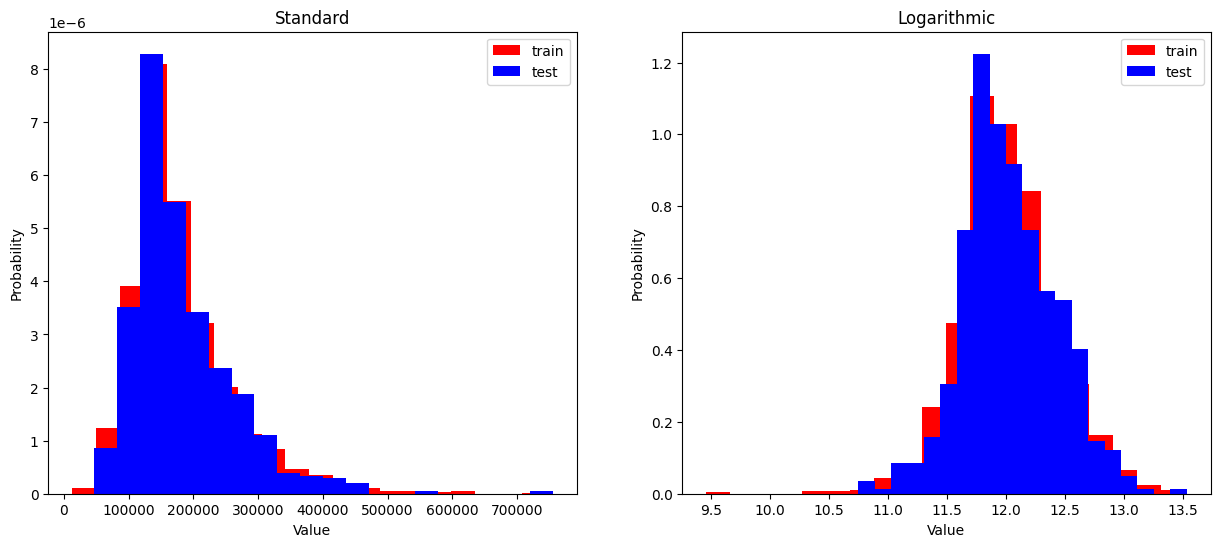

In [15]:
import matplotlib.pyplot as plt
plot_both_distributions(Y_train, Y_test)

Как видите, если прологарифмировать таргеты, то их распределение станет более похоже на гауссовское. Интуиция подсказывает, что линейная регрессия с функцией потерь MSE должна лучше учиться на таких таргетах.

Попробуйте написать класс, который во время обучения логарифмирует таргет, а во время предсказания — наоборот, экспоненциирует. После чего обучите оба метода на обучающих данных и сравните значения метрик MAE и MSLE на тесте.

Что должно быть в этом классе:
- Класс должен называться ```ExponentialLinearRegression```
- Класс должен иметь такой же fit-predict интерфейс, как и было до этого. На вход он получает оригинальные X и Y, а уже внутри происходит логарифмирование или экспоненциирование.
- Внутри этой модели будет работать [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Хочется, чтобы этому классу можно было передавать аргументы инициализации с помощью *args и **kwargs
- Чтобы потом этот класс можно было использовать в [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) в следующих пунктах, у него должны быть реализованы 5 методов
    1. ```__init__(self, *args, **kwargs)``` &mdash; все полученные аргументы передаются дальше в Ridge.
    2. ```fit(self, X, Y)``` &mdash; обучает класс, возвращает self.
    3. ```predict(self, X)``` &mdash; делает предсказание.
    4. ```get_params(deep=True)``` &mdash; возвращает dict с параметрами модели. Больше подробностей [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
    5. ```set_params(**params)``` &mdash; передает нужные параметры в модель. Больше подробносте [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
- Есть два подхода к тому как сделать все нужные методы:
    - Отнаследоваться от класса Ridge и переопределить методы fit и predict, внутри вызывая super() от отцовского класса.
    - Отнаследоваться от класса RegressorMixin и внутренним атрибутом класса сделать Ridge. Тогда все методы нужно будет писать руками.

In [16]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class ExponentialLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, *args, **kwargs):
        # Инициализируем Ridge с переданными аргументами
        self.ridge = Ridge(*args, **kwargs)

    def fit(self, X, Y):
        # Логарифмируем таргет перед обучением
        self.ridge.fit(X, np.log(Y))
        return self

    def predict(self, X):
        # Экспоненциируем предсказания
        log_preds = self.ridge.predict(X)
        return np.exp(log_preds)

    def get_params(self, deep=True):
        # Возвращаем параметры Ridge
        return self.ridge.get_params(deep=deep)

    def set_params(self, **params):
        # Устанавливаем параметры Ridge
        self.ridge.set_params(**params)
        return self


In [17]:
classic_regressor = Ridge()
exponential_regressor = ExponentialLinearRegression()

classic_regressor.fit(X_train, Y_train)
exponential_regressor.fit(X_train, Y_train)

classic_prediction = classic_regressor.predict(X_test)
exponential_prediction = exponential_regressor.predict(X_test)

print(f"MAE  : Classic : {mean_absolute_error(Y_test, classic_prediction)}  Exponential : {mean_absolute_error(Y_test, exponential_prediction)}")
print(f"MSLE : Classic : {root_mean_squared_logarithmic_error(Y_test, classic_prediction)} Exponential : {root_mean_squared_logarithmic_error(Y_test, exponential_prediction)}")

MAE  : Classic : 23821.977761006816  Exponential : 26818.69978654439
MSLE : Classic : 0.1950062123328133 Exponential : 0.21601027716185428


#### 4 Кроссвалидация и МАЕ

Введите число, округлённое до целого:
- MAE обычной линейной регрессии (без регуляризации и с дефолтными параметрами) на объединении обучающей и тестовой выборок, посчитанную по кросс-валидации.
В качестве параметра cv в кросс-валидации вам нужно указать KFold(n_splits=5, shuﬄe=True, random_state=42)

In [18]:
import numpy as np
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression

# Создаём объект кросс-валидатора KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаем модель линейной регрессии
classic_regressor = LinearRegression()

# Объединяем данные (предположим, что X_train, X_test, Y_train, Y_test — массивы NumPy)
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((Y_train, Y_test), axis=0)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = cross_validate(
    estimator=classic_regressor,  # модель
    X=X_all,  # матрица наблюдений X
    y=y_all,  # вектор ответов y
    cv=kf,  # кросс-валидатор
    scoring='neg_mean_absolute_error',  # метрика
    return_train_score=True  # подсчёт метрики на тренировочных фолдах
)

# Извлекаем метрики по MAE (они отрицательные из-за 'neg_mean_absolute_error')
mae_scores = -cv_metrics['test_score']

# Средний MAE
mean_mae = np.mean(mae_scores)

# Округляем до целого
rounded_mae = round(mean_mae)

print("MAE, округлённое до целого:", rounded_mae)


MAE, округлённое до целого: 23225


### 5. Линейная модель своими руками

В этом разделе вы напишете собственный класс линейной модели, чтобы лучше разобраться, как работает обучение с помощью SGD.

Линейная модель делает предсказание по такой формуле:
$$
\widehat{y}(x) = x^T \widehat{\theta}
$$
Здесь $\widehat{\theta}$ &mdash; обучаемые параметры, $x$ &mdash; вектор фичей данного примера.
Оценка $\widehat{\theta}$ находятся из задачи минимизации лосс функции:

$$
F(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left(Y_i - x_i^T \theta\right)^2 + \lambda \theta^T\theta \longrightarrow \min_{\theta \in \mathbb{R}^d}
$$

Эту задачу минимизации будем решать градиентным спуском. Для этого реализуем этот метод ввиде класса с методами fit-predict.
Что в нем должно быть:
1. Класс должен называться ```SGDLinearRegressor```
2. Класс должен быть отнаследован от sklearn-овского класса [RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html)
3. Класс должен инициализироваться со следующими гиперпараметрами:

    * ```lr``` — learning rate. Длина шага градиентного спуска

    * ```regularization``` — коэффициент $\lambda$ из формулы выше
    
    * ```delta_converged``` — устанавливает условие окончание обучение. В тот момент когда норма разности весов на соседних шагах градиентного спуска меньше чем ```delta_converged``` метод прекращает обновлять веса
    
    * ```max_steps``` — максимальное число шагов градиентного спуска
    
    * ```batch_size``` — размер батча

4. Реализуйте **стохастический** градиентный спуск. На каждом шагу градиентного спуска должен формироваться батч размера ```batch_size``` из матрицы признаков. Это нужно для того чтобы метод быстрее сходился. Батч может выбираться случайно на каждом шаге градиентного спуска, либо каждую эпоху можно перемешивать трейн выборку и итерироваться батчами по ней.


Обратите внимание при реализации SGD на следующие моменты (частые ошибки):
* не перепутайте, какие коэффициенты в SGD стоят при самой функции потерь, а какие — при регуляризационном члене
* для остановки нужно сравнивать норму, а не ее квадрат
* для правильного решения нужно не итерироваться по батчу,  а перемножать матрицы (иначе не зайдет по TL)


In [ ]:
class SGDLinearRegressor(RegressorMixin):
    def __init__(
        self,
        lr=0.01,
        regularization=1.,
        delta_converged=1e-2,
        max_steps=1000,
        batch_size=64,
    ):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None
        self.b = None

    def fit(self, X, Y):
        

    def predict(self, X):
        # <Your code here>
        pass

In [21]:
# Неправильный вариант
import numpy as np
from sklearn.base import RegressorMixin

class SGDLinearRegressor(RegressorMixin):
    def __init__(
        self,
        lr=0.01,
        regularization=1.,
        delta_converged=1e-2,
        max_steps=1000,
        batch_size=64,
    ):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None  # веса модели
        self.b = None  # смещение модели

    def fit(self, X, Y):
        n_samples, n_features = X.shape
        self.W = np.zeros(n_features)
        self.b = 0

        for step in range(self.max_steps):
            # Случайно перемешиваем данные для стохастического градиентного спуска
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            # Итерация по батчам
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                Y_batch = Y_shuffled[i:i + self.batch_size]

                # Предсказание
                Y_pred = np.dot(X_batch, self.W) + self.b

                # Вычисление градиентов
                error = Y_pred - Y_batch
                grad_W = (2 / len(Y_batch)) * np.dot(X_batch.T, error) + 2 * self.regularization * self.W
                grad_b = (2 / len(Y_batch)) * np.sum(error)

                # Обновление весов
                W_old = self.W.copy()
                self.W -= self.lr * grad_W
                self.b -= self.lr * grad_b

                # Проверка сходимости
                if np.linalg.norm(self.W - W_old) < self.delta_converged:
                    return self

        return self

    def predict(self, X):
        return np.dot(X, self.W) + self.b


In [22]:
# Правильный вариант
class SGDLinearRegressor(RegressorMixin):
    def __init__(self,
                 lr=0.01, regularization=1., delta_converged=1e-3, max_steps=1000,
                 batch_size=64):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None
        self.b = None

    def fit(self, X, Y):
        n_samples, n_features = X.shape # n_samples - количество строк (количество примеров); n_features - количество признаков
        # Инициализация весов и смещения
        self.W = np.zeros(n_features)
        self.b = 0

        for step in range(self.max_steps):
            # Перемешиваем данные для создания случайных батчей
            indices = np.arange(n_samples) # аналог функции 'range' только создается одномерный массив 
            np.random.shuffle(indices) # перемешаем индексы
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for start_idx in range(0, n_samples, self.batch_size): # от 0 до n_samples с шагом batch_size
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                Y_batch = Y_shuffled[start_idx:end_idx]

                # Предсказание
                Y_pred = np.dot(X_batch, self.W) + self.b
                
                # Вычисление градиентов
                error = Y_pred - Y_batch
                grad_w = (2 / self.batch_size) * np.dot(X_batch.T, error) + 2 * self.regularization * self.W
                grad_b = (2 / self.batch_size) * np.sum(error)

                # Обновление весов и смещения
                self.W -= self.lr * grad_w
                self.b -= self.lr * grad_b

            # Проверка условия остановки
            if np.linalg.norm(self.lr * grad_w) < self.delta_converged:
                break

    def predict(self, X):
        return np.dot(X, self.W) + self.b

In [25]:
# Check yourself
model = SGDLinearRegressor()
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
print(Y_test.shape, prediction.shape)
print("MAE : ", mean_absolute_error(Y_test, prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_test, prediction))

(586,) (586,)
MAE :  25724.050949730074
Mean log :  0.18863716956644616


### 6. Категориальные признаки

В самом начале ноутбука мы отбросили категориальные фичи, хотя они могут помочь нам сделать модель лучше. Давайте же научимся ими пользоваться.

Самый простой подход — это закодировать значения категориального признака числами, скажем, от $0$ до $C-1$, где $C$ — количество значений категориального признака. Иногда это может сработать, но для этого нужно, чтобы между значениями признака были определены отношения больше/меньше (такие признаки называются _ординальными_), причём соотношения между значениями должны быть более-менее линейными. В целом, не очень частая ситуация, поэтому так мы делать не будем.

Вместо этого мы будем использовать OneHotEncoding. Пусть некоторая категориальная фича имеет $C$ уникальных значений. Давайте эту фичу закодируем в виде $C$ столбцов, каждый из которых соответствует некоторому уникальному значению категориальной фичи. Для каждого элемента выборки будем класть единичку в столбец, соответствующий этой фиче, и нолики в остальные.

У этого метода есть недостаток. Если категориальная фича принимает слишком много значений, то вы нагенерируете много новых столбцов, каждый из которых будет содержать мало информации. Из-за них моделька может переобучиться.

Этот метод имплементирован [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). У него есть пара важных гиперпараметров, которые стоит упомянуть:
- ```handle_unknown``` &mdash; управляет обработкой незнакомых категорий на этапе `transform`. Число уникальных значений (и число столбцов) настраивается на обучающей выборке, и при дальнейшем применении может появиться значение, которого ещё не было. Если указать ```handle_unknown="ignore"```, все поля для такого объекта будут заполнены нулями.
- ```drop``` &mdash; если делать one-hot-encoding так как это описано выше, то сумма всех столбцов, соответствующих значениям категориальной фичи, будет равна единичному вектору. А такой вектор уже есть (он соответствует свободному члену). То есть признаки становятся линейно зависимыми, и это сломает процесс обучения линейной модели. Поэтому есть смысл для каждой фичи отбрасывать одну из получившихся колонок (```drop="first"```) или хотя бы делать это только для бинарных фичей (```drop="if_binary"```)

В этом пункте вам надо еще раз предобработать данные, добавив в них часть категориальных фичей, закодированных OneHotEncoding-ом. После этого обучите классификатор заново и выбейте лучшую метрику на тестовой выборке. А именно, мы добавим фичи "Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning". Используйте значение параметра handle_unknown="ignore".

*Замечание.* На практике в некоторых версиях scikit-learn есть проблема с совместимостью `handle_unknown="ignore"` и `drop="first"` одновременно, поэтому вторым можно пожертвовать.

Класс будет наследоваться от BaseDataPreprocessor, так что в него можно будет передавать нужные для BaseDataPreprocessor параметры. Также это позволит не переписывать заново то, что происходит в базовом классе, а просто взывать к ним с помощью конструкции `super`.


In [26]:
from sklearn.preprocessing import OneHotEncoder
interesting_columns = ["Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning"]

class OneHotPreprocessor(BaseDataPreprocessor):
    def __init__(self, columns_to_encode: List[str], continue_columns: Optional[List[str]]):
        super().__init__(needed_columns=continue_columns)
        self.columns_to_encode = columns_to_encode
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, data: pd.DataFrame, *args):
        # Fit the encoder only on the specified columns
        self.encoder.fit(data[self.columns_to_encode])
        # Fit the scaler using the parent class method 
        super().fit(data, *args) # Это для масштабирования числовых признаков.
                                 # В родительском методе fit у BaseDataPreprocessor есть фильтрация needed_columns,
                                 # так что ничего страшного в том, что мы передаем все данные (категориальные + числовые)
        return self

    def transform(self, data: pd.DataFrame) -> np.array:
        # One-hot encode the specified columns
        data_encoded = self.encoder.transform(data[self.columns_to_encode])
        # Scale the other columns using the parent class method
        data_scaled = super().transform(data) # Тут так же в методе transform у родительского класса BaseDataPreprocessor есть фильтрация needed_columns
        # Concatenate the encoded and scaled data
        return np.concatenate((data_encoded.toarray(), data_scaled), axis=1)

In [27]:
# Без кодирования
model = ExponentialLinearRegression()
model.fit(X_train, Y_train)

base_prediction = model.predict(X_test)
print("RMSLE :", root_mean_squared_logarithmic_error(Y_test, base_prediction))

# C one hot кодированием
ohe_preprocessor = OneHotPreprocessor(interesting_columns, continuous_columns)
X_train_ohe = ohe_preprocessor.fit_transform(data_train)
X_test_ohe = ohe_preprocessor.transform(data_test)

model = ExponentialLinearRegression()
model.fit(X_train_ohe, Y_train)

ohe_prediction = model.predict(X_test_ohe)
print("RMSLE (One hot encoder) :", root_mean_squared_logarithmic_error(Y_test, ohe_prediction))

RMSLE : 0.21601027716185428
RMSLE (One hot encoder) : 0.1856098280071807


### 7. Pipeline

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс — pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)).

**7. Напишите пайплайн, объединяющий использованную нами базовую предобработку данных (BaseDataPreprocessor и OneHotPreprocessor), а также линейную регрессию с L2-регуляризацией, и сдайте его в Контест.**

In [30]:
from sklearn.pipeline import Pipeline
def make_ultimate_pipeline(continuous_columns, categorical_columns):
    one_hot_preprocessor = OneHotPreprocessor(columns_to_encode=categorical_columns, continue_columns=continuous_columns)
    
    # Пайплайн с двумя препроцессорами и линейной регрессией
    pipeline = Pipeline([
        ('preprocessor' BaseDataPreprocessor()),
        ('preprocessorOneHot', one_hot_preprocessor), # Масштабирование данных числовых фичей включено
        ('regressor', ExponentialLinearRegression())
    ])
    
    return pipeline

In [31]:
pipeline = make_ultimate_pipeline(continuous_columns, categorical_columns)
pipeline.fit(data_train, Y_train)
y_pred = pipeline.predict(data_test)

print("RMSLE (Pipeline):", root_mean_squared_logarithmic_error(Y_test, y_pred))

RMSLE (Pipeline): 0.16879940919250136
